In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image
from numpy import asarray

In the previous session we had generated robot trajectory using open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us repeat but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

By convention, we use +ve for counter-clockwise and -ve for clockwise motion

You can use cubic_spiral() from previous notebook

In [ ]:
v = 1.0
dt = 0.1
num_pts = 5
num_st_pts = int(v/dt)

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, n)
    #-2*x**3 + 3*x**2
    thetas = theta_i + (theta_f-theta_i)*(-2*x**3+3*x**2)
    return thetas
    
def straight(dist, curr_pose, n=num_st_pts):
    x0, y0, t0 = curr_pose
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    #write your code here
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    #x, y are just linear interpolations between 
    #(x0,xf) and (y0,yf) respectively
    x = np.linspace(x0, xf, int(dist*n))
    y = np.linspace(y0, yf, int(dist*n))

    #t0 does not change for straight
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant (n) for desired turn radius
    # Ex: n = 50, v = 1 is for 3m radius
    # n = 100 is for 6m radius
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2), radius=3.0):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    scale = {'straight': 15, 'turn': int(50*radius/3.0)}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        print(f'manoeuvre {manoeuvre} scale {scale[manoeuvre]}')
        # call straight() or turn() depending on manoeuvre
        # single statement can be used in Python to achieve this
        #func is a dictionary containing the function names
        px, py, pt = func[manoeuvre](command, curr_pose, scale[manoeuvre])
        #px, py, pt = your code here
        #last pose of previous manoeuvre recorded
        curr_pose = px[-1],py[-1],pt[-1] 
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return np.vstack([x, y, t])

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

manoeuvre straight scale 15
manoeuvre turn scale 50
manoeuvre straight scale 15
manoeuvre turn scale 50


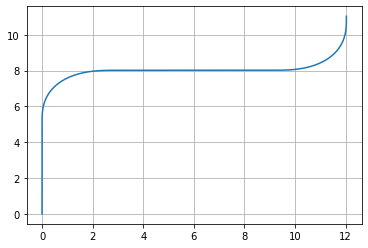

In [ ]:
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
x, y, _ = generate_trajectory(route)
plt.figure()
plt.plot(x, y)
plt.grid()

## Convert 

Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

In [ ]:
np.linalg.norm((1, 1),1)

2.0

Corners [(0, 7), (11, 7)]
prev_x:3.0, prev_y:7.0, prev_t:0.00
prev_x:11.0, prev_y:10.0, prev_t:1.57
manoeuvre straight scale 15
manoeuvre turn scale 50
manoeuvre straight scale 15
manoeuvre turn scale 50
manoeuvre straight scale 15
Corners [(0, 7), (11, 7)]
prev_x:2.0, prev_y:7.0, prev_t:0.00
prev_x:11.0, prev_y:9.0, prev_t:1.57
manoeuvre straight scale 15
manoeuvre turn scale 33
manoeuvre straight scale 15
manoeuvre turn scale 33
manoeuvre straight scale 15


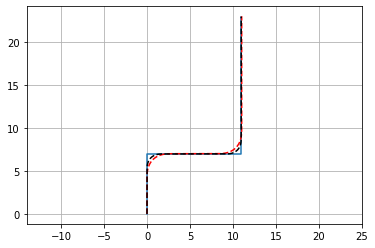

In [ ]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 8, 12
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

y3 = list(range(s2, 2*s2))
x3 = [x2[-1]]*s2

x, y = x1[:-1]+x2+x3, y1[:-1]+y2+y3
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(x, y)
plt.grid()

#find all corner points and plot it
def find_all_corners(x, y):
  corners, turn_sign = [], []
  for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
    slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
    if np.abs(slope) > 0.0:
        #your code here
        corners.append((x2, y2))
        turn_sign.append(np.sign(slope))
  return corners, turn_sign

def find_straight_length(pt, prev_x, prev_y):
  x, y = pt
  dx, dy = x-prev_x, y-prev_y
  distance = np.linalg.norm((dx, dy))
  return distance

# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
#assume route is (a) bookended by straights (b) turns are only 90

def get_motion_primitives(x, y, r=2.5,prev_theta = np.pi/2):
  corners, turn_signs = find_all_corners(x, y)
  print(f"Corners {corners}")
  route = []
  prev_x, prev_y = 0, 0 
  # prev_theta = np.pi/2
  for corner_pt, turn_sign in zip(corners, turn_signs):
    distance = find_straight_length(corner_pt, prev_x, prev_y) #complete the argument
    route.append(("straight", distance - r))
    route.append(("turn",turn_sign*90))
    #get starting pose of next straight segment
    prev_theta += (turn_sign*np.pi/2) #complete this using turn_sign and np.pi/2 variables
    prev_x, prev_y = corner_pt[0] + r*np.cos(prev_theta), corner_pt[1]+r*np.sin(prev_theta)
    print(f"prev_x:{prev_x}, prev_y:{prev_y}, prev_t:{prev_theta:0.2f}")
  #Final straight segment
  distance = find_straight_length((x[-1],y[-1]), prev_x, prev_y)
  route.append(("straight", distance))
  return route

#3m turn  
rad = 3
route = get_motion_primitives(x, y, r=rad)
smooth_x, smooth_y, _ = generate_trajectory(route, init_pose = (0,0,-np.pi/2),radius=rad)
plt.plot(-smooth_x, -smooth_y, 'r--')

#2m turn
rad = 2
route = get_motion_primitives(x, y, r=rad)
smooth_x, smooth_y, _ = generate_trajectory(route, radius=rad)
plt.plot(smooth_x, smooth_y, 'k--')

# More complex example
Borrow the Grid world code from last class's notebook. Get the Djikstra path and smoothen it using the routine from above

In [ ]:
grid = np.load("./sample_data/robot_grid.npy")
print(grid.shape)

(20, 20)


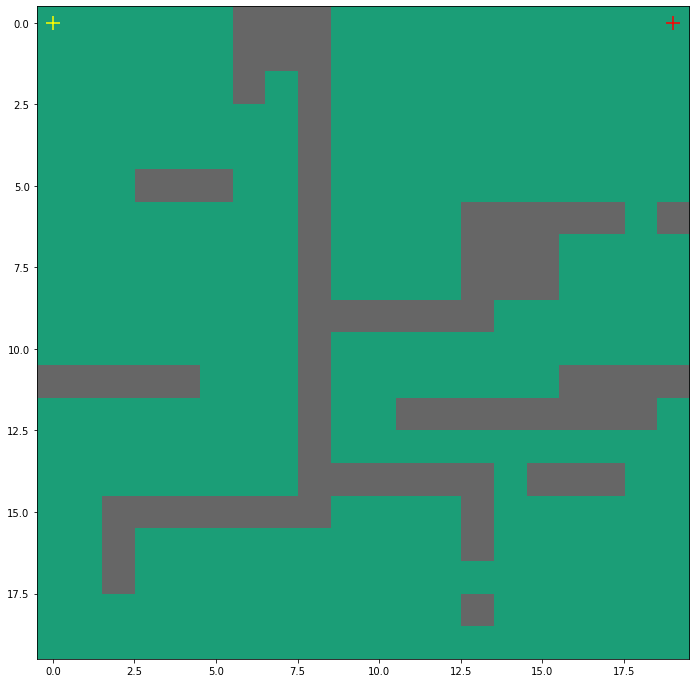

In [ ]:
# use np.load to load a grid of 1s and 0s
# 1 - occupied 0- free
# you can define your own start/ end
start = (0, 0)
goal = (0, 19)

# visualize the start/ end and the robot's environment
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()

In [ ]:
from networkx.generators.lattice import grid_graph
#initialize graph
grid_size = grid.shape
# G = nx.grid_2d_graph(*grid_size)
G = nx.grid_2d_graph(grid_size[0],grid_size[1])

deleted_nodes = 0 # counter to keep track of deleted nodes
#nested loop to remove nodes that are not connected
#free cell => grid[i, j] = 0
#occupied cell => grid[i, j] = 1
num_nodes = 0
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    if grid[i, j] == 1: 
      G.remove_node((i,j)) #complete code
      num_nodes += 1

print(f"removed {num_nodes} nodes")
print(f"number of occupied cells in grid {np.sum(grid)}")

removed 77 nodes
number of occupied cells in grid 77


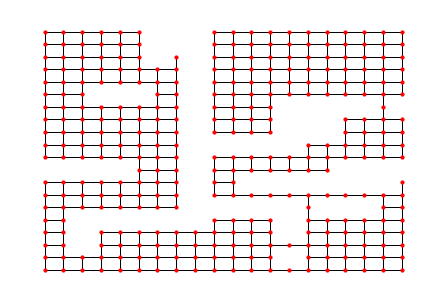

In [ ]:
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, pos=pos, node_color='red', node_size=10)

In [ ]:
dijkstra_path = nx.shortest_path(G,start,goal) #complete code
print(dijkstra_path)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (5, 19), (4, 19), (3, 19), (2, 19), (1, 19), (0, 19)]


In [ ]:
x= []
y = []
for i,j in dijkstra_path:
  x.append(i)
  y.append(j)
print(x)
print(y)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 11, 12, 13, 14, 14, 14, 14, 14, 15, 16, 17, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 15, 14, 13, 13, 13, 13, 13, 12, 11, 10, 10, 10, 10, 10, 9, 9, 9, 8, 7, 7, 7, 6, 5, 5, 4, 3, 2, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 4, 3, 2, 1, 1, 1, 1, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 14, 13, 12, 11, 10, 10, 10, 10, 11, 12, 13, 14, 14, 15, 16, 16, 16, 17, 18, 18, 18, 19, 19, 19, 19, 19, 19]


In [ ]:
radius = 0.3
route = get_motion_primitives(x, y, radius,0)

print(route)

Corners [(10, 0), (10, 5), (14, 5), (14, 1), (18, 1), (18, 3), (17, 3), (17, 14), (13, 14), (13, 10), (10, 10), (10, 14), (9, 14), (9, 16), (7, 16), (7, 18), (5, 18), (5, 19)]
prev_x:10.0, prev_y:0.3, prev_t:1.57
prev_x:10.3, prev_y:5.0, prev_t:0.00
prev_x:14.0, prev_y:4.7, prev_t:-1.57
prev_x:14.3, prev_y:1.0, prev_t:0.00
prev_x:18.0, prev_y:1.3, prev_t:1.57
prev_x:17.7, prev_y:3.0, prev_t:3.14
prev_x:17.0, prev_y:3.3, prev_t:1.57
prev_x:16.7, prev_y:14.0, prev_t:3.14
prev_x:13.0, prev_y:13.7, prev_t:4.71
prev_x:12.7, prev_y:10.0, prev_t:3.14
prev_x:10.0, prev_y:10.3, prev_t:1.57
prev_x:9.7, prev_y:14.0, prev_t:3.14
prev_x:9.0, prev_y:14.3, prev_t:1.57
prev_x:8.7, prev_y:16.0, prev_t:3.14
prev_x:7.0, prev_y:16.3, prev_t:1.57
prev_x:6.7, prev_y:18.0, prev_t:3.14
prev_x:5.0, prev_y:18.3, prev_t:1.57
prev_x:4.7, prev_y:19.0, prev_t:3.14
[('straight', 9.7), ('turn', 90), ('straight', 4.4), ('turn', -90), ('straight', 3.3999999999999995), ('turn', -90), ('straight', 3.4000000000000004), ('

manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15
manoeuvre turn scale 5
manoeuvre straight scale 15


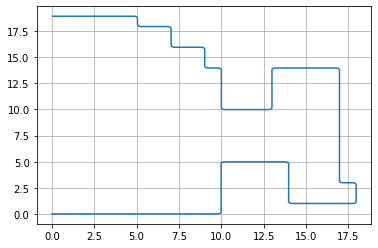

In [ ]:
xs, ys, _ = generate_trajectory(route,(0, 0,0),radius)
plt.figure()
plt.plot(xs,ys)
plt.grid()

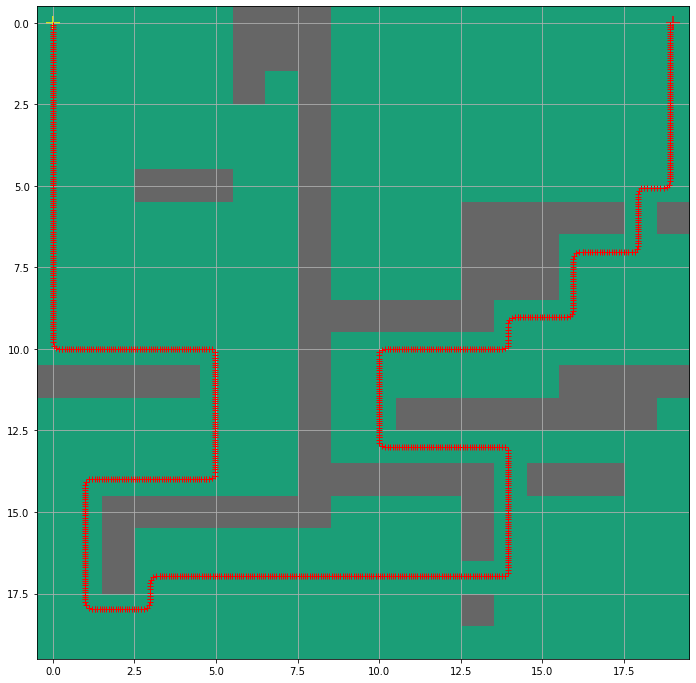

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
# for s in dijkstra_path[1:]:
#   ax.plot(s[1], s[0],'r+')
ax.plot(ys[1:], xs[1:],'r+')
plt.grid()

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.


There are 3 more advanced manouevres that you may need in practice

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs